# Playing with The Mondrian Process

This is a notebook for playing with [The Mondrian Process](http://danroy.org/papers/RoyTeh-NIPS-2009.pdf). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

%matplotlib inline

## Basic Functions

In [2]:
def dimensions(box, size=None):
    if box is None:
        if size is not None:
            return np.zeros(size)
        else: 
            raise ValueError('If box is not provided, you must specify size.')
            
    return np.diff(box, axis=1).flatten()

def linear_dimension(box):
    if box is None:
        return 0
    return dimensions(box).sum()

def interval_difference(outer_interval, inner_interval):
    lower_outer, upper_outer = outer_interval
    lower_inner, upper_inner = inner_interval
    return [lower_outer, lower_inner], [upper_inner, upper_outer]

def sample_interval_difference(outer_interval, inner_interval):
    intervals = interval_difference(outer_interval, inner_interval)
    dimensions = [np.diff(intervals[0])[0], np.diff(intervals[1])[0]]
    chosen_interval_index = np.random.choice(range(len(intervals)), p=dimensions/np.sum(dimensions))
    chosen_interval = intervals[chosen_interval_index]
    return np.random.uniform(low=chosen_interval[0], high=chosen_interval[1], size=1)[0], chosen_interval_index

def random_axis(dimensions):
    return np.random.choice(range(len(dimensions)), 
                            p=dimensions/np.sum(dimensions))

def random_cut(box, axis):
    return np.random.uniform(low=self.box[axis][0], 
                             high=self.box[axis][1], 
                             size=1)[0]

def cost_next_cut(linear_dimension):
    return np.random.exponential(scale=1.0/linear_dimension, size=1)[0]

def new_cut_proposal(self):
    cost = self.cost_next_cut()
    axis = self.random_axis()
    cut_point = self.random_cut(axis)
    return cost, axis, cut_point

def cut_boxes(box, cut_axis, cut_point):
    left = box.copy()
    right = box.copy()
    low, high = box[cut_axis]

    if cut_point <= low or cut_point >= high:
        raise ValueError('Point is not in interval.')

    left[cut_axis] = [low, cut_point]
    right[cut_axis] = [cut_point, high]
    return left, right

## Growing Mondrians 

Mondrian Processes are methodical constructions of random kd-trees. A sort of projective family of distribution of kd-trees with certain complexity restrictions. Naïvely, given an axis-aligned box $\Theta =\Theta_0 \times \cdots\times \Theta_{m-1} \subseteq \mathbb{R}^m$ and a budget $b\in \mathbb{R}^{\geq 0}$, you build cuts recurrently as follows:

1. Sample $c\sim \text{Exp}(\sum_m \mu(\Theta_m))$, where $\mu$ is some measure (you can even have a different measure for each axis if you like). If it is too expensive ($c > b$), you've reached a leaf. 
2. Else, continue selecting at random first an axis to cut (sampling at random in proportion to the measure of each interval) and then a point on the chosen interval (sampling uniformly). 
3. Make the cut, obtain two complementary boxes, and try to get cuts for each of them assuming a new budget of $b-c$. 

In our current implementation, let us use for $\mu$ the Lebesgue measure (since we will only calculating it for unions of finite intervals, it is just a simple sum of lengths).

The first cool fact about Mondrians is that on each cut, the resulting two new Mondrians downstream are conditionally independent from each other over the base that spawned them. 

A second result related to this construction states that if $\Xi=\Xi_0 \times\cdots\times\Xi_{m-1}\subset \Theta\subset\mathbb{R}^m$ and there is a Mondrian $\mathfrak{p}$ of budget $b$ on $\Theta$, then $\mathfrak{p}|_{\Xi}$, its restriction to the smaller box, is also a Mondrian of the same budget. This is what the authors of the original paper call _consistency_. From this property you can derive a process for sampling a Mondrian on $\Theta$ conditional to its restriction on a smaller domain $\Xi$. In that case, assume you already have a Mondrian $\mathfrak{q}$ built on $\Xi$. Sampling $\mathfrak{p}$ on $\Theta$ so that $\mathfrak{p}|_{\Xi} = \mathfrak{q}$ would go roughly as follows:

1. Sample $c\sim \text{Exp}(\sum_m \mu(\Theta_m\setminus\Xi_m))$, this would be the cost of your first cut outside of $\Xi$.
2. If the first cut of $\mathfrak{q}$ happens to be cheaper than $c$, then you simply extend this cut to your larger domain and continue the process on each side, now with smaller conditionals on the two sides of $\mathfrak{q}$ that it defines. The cost of this cut is the original cost of it in the smaller domain. 
3. Else, sample a cut in a similar fashion as in the original algorithm, taken into consideration that you will have to sample it from the area where the cut will not pass through $\Xi$. 

The function `grow_mondrian` outputs a Mondrian on a given box and provided a budget. An optional parameter allows you to set a Mondrian on a smaller domain as condition. It handles the general (non-conditional) case by assuming you are conditioning on an empty Mondrian.

In [3]:
class Mondrian(object):
    def __init__(self, box, budget):
        self.box = box
        self.budget = budget
        self.cut_point = None
        self.cut_axis = None
        self.cut_budget = None
        self.left = None
        self.right = None
        
    def extended_by(self, box):
        if self.box is None:
            return True
        return all((box[:, 0] <= self.box[:, 0]) & (box[:, 1] >= self.box[:, 1]))
    
    def contains(self, point):
        if self.box is None:
            return False
        return all(box[:,0] <= point) & (box[:,1] >= point)
    
    def has_cut(self):
        return self.cut_axis is not None
    
    def is_empty(self):
        return self.box is None
    
def grow_mondrian(box, budget, given_mondrian=None):
    if given_mondrian is None:
        given_mondrian = Mondrian(None, budget)

    if not given_mondrian.extended_by(box):
        raise ValueError('Incompatible boxes: given mondrian box must be contained in new box.')
    
    mondrian = Mondrian(box, budget)
    
    cost = cost_next_cut(linear_dimension(box) - linear_dimension(given_mondrian.box))
    
    next_budget = budget - cost
    
    given_mondrian_next_budget = given_mondrian.cut_budget if given_mondrian.has_cut() else 0
    
    
    if next_budget < given_mondrian_next_budget:        
        if given_mondrian.has_cut():
            mondrian.cut_axis = given_mondrian.cut_axis
            mondrian.cut_point = given_mondrian.cut_point
            mondrian.cut_budget = given_mondrian_next_budget

            left, right = cut_boxes(box, mondrian.cut_axis, mondrian.cut_point)

            mondrian.left = grow_mondrian(left, given_mondrian_next_budget, given_mondrian.left)
            mondrian.right = grow_mondrian(right, given_mondrian_next_budget, given_mondrian.right)
    else:
        dimensions_outer = dimensions(box)
        dimensions_inner = dimensions(given_mondrian.box, size=len(box))
        mondrian.cut_axis = random_axis(dimensions_outer - dimensions_inner)
        outer_interval = box[mondrian.cut_axis]
        
        if given_mondrian.is_empty():
            inner_interval = [outer_interval[0], outer_interval[0]]
        else:
            inner_interval = given_mondrian.box[mondrian.cut_axis]

        mondrian.cut_point, cut_side = sample_interval_difference(outer_interval, inner_interval)
        mondrian.cut_budget = next_budget
        
        left, right = cut_boxes(box, mondrian.cut_axis, mondrian.cut_point)

        if cut_side: # entire given_mondrian to the left
            mondrian.left = grow_mondrian(left, next_budget, given_mondrian)
            mondrian.right = grow_mondrian(right, next_budget, Mondrian(None, next_budget))
        else: # all given_mondrian to the right
            mondrian.left = grow_mondrian(left, next_budget, Mondrian(None, next_budget))
            mondrian.right = grow_mondrian(right, next_budget, given_mondrian)
            
    return mondrian

## Plotting 2-dimensional Mondrians

In [94]:
def get_random_color():
    return np.random.choice(['dodgerblue', 'orangered', 'yellow', 'white'], 1)[0]
    
def box_2d(box, color=None, alpha=None, ellipse=True):
    low_x, high_x = box[0]
    low_y, high_y = box[1]
    width = high_x - low_x
    height = high_y - low_y
    
    if color is None:
        color = 'white'
    if alpha is None:
        alpha = 1
        
    lower_left_corner = np.array([low_x, low_y])
    
    if ellipse:
        centre_point = lower_left_corner + np.array([width/2.0, height/2.0])
        return mpatches.Ellipse(centre_point, width, height, color=color, ec='black', 
                                linewidth=2, alpha=alpha)
    
    return mpatches.Rectangle(lower_left_corner, width, height, 
                              color=color, ec='black', linewidth=2, 
                              alpha=alpha)

def boxes(m, box_collection, color=None, ellipse=False):
    random_color = False
    
    if color == 'true_mondrian':
        random_color = True
        color = get_random_color()
    
    box_collection.append(box_2d(m.box, color, ellipse=ellipse))
    
    if m.has_cut():
        color = 'true_mondrian' if random_color else color
        boxes(m.left, box_collection, color, ellipse=ellipse)
        boxes(m.right, box_collection, color, ellipse=ellipse)
        
def plot_coloured_mondrian(m, ax, color=None, given_mondrian=None, ellipse=False):
    if given_mondrian is None:
        given_mondrian = Mondrian(None, budget)
        
    box_collection = []
    boxes(m, box_collection, color, ellipse=ellipse)
    
    if not given_mondrian.is_empty():
        box_collection.append(box_2d(given_mondrian.box, 
                                     color='black', alpha=0.1))
        
    collection = PatchCollection(box_collection, match_original=True)
    ax.add_collection(collection)
    
    ax.axis('off')
    ax.autoscale()
    #plt.show()
    
def random_mondrians(box, budget, given_mondrian=None, color=None, rows=1, columns=1, figsize=(15, 15), ellipse=False):
    if given_mondrian is None:
        given_mondrian = Mondrian(None, budget)
        
    if rows == 1 and columns == 1:
        fig, ax = plt.subplots(figsize=figsize)  
        plot_coloured_mondrian(grow_mondrian(box, budget, given_mondrian), 
                               ax, color=color, given_mondrian=given_mondrian, ellipse=ellipse)
    else:
        fig, ax = plt.subplots(rows, columns, figsize=figsize)  

        for row in range(rows):
            for col in range(columns):
                if not given_mondrian.is_empty() and row == 0 and col ==0:
                    plot_coloured_mondrian(given_mondrian, ax[row, col], color=color, ellipse=ellipse)
                else:
                    plot_coloured_mondrian(grow_mondrian(box, budget, given_mondrian), 
                                           ax[row, col], color=color, given_mondrian=given_mondrian, ellipse=ellipse)
                    
def growing_mondrians(initial_box, budget, rows=1, columns=1, figsize=(15, 15)):
    if rows == 1 and columns == 1:
        fig, ax = plt.subplots(figsize=figsize)  
        plot_coloured_mondrian(grow_mondrian(box, budget), 
                               ax, color=None)
    else:
        fig, ax = plt.subplots(rows, columns, figsize=figsize)  
        
        given_mondrian = Mondrian(None, budget)
        box = initial_box
        for row in range(rows):
            for col in range(columns):
                mondrian = grow_mondrian(box, budget, given_mondrian)
                plot_coloured_mondrian(mondrian, ax[row, col], color=None, given_mondrian=given_mondrian)
                given_mondrian = mondrian
                box = 2 * box

## Sampling Mondrians on a 1-by-1 square

Let us sample Mondrians of different budgets from a 1-by-1 square. I am colouring block with colors that mimick the way Mondrian did his paintings. 

In [95]:
box = np.array([[0.0, 1.0], [0.0, 1.0]])

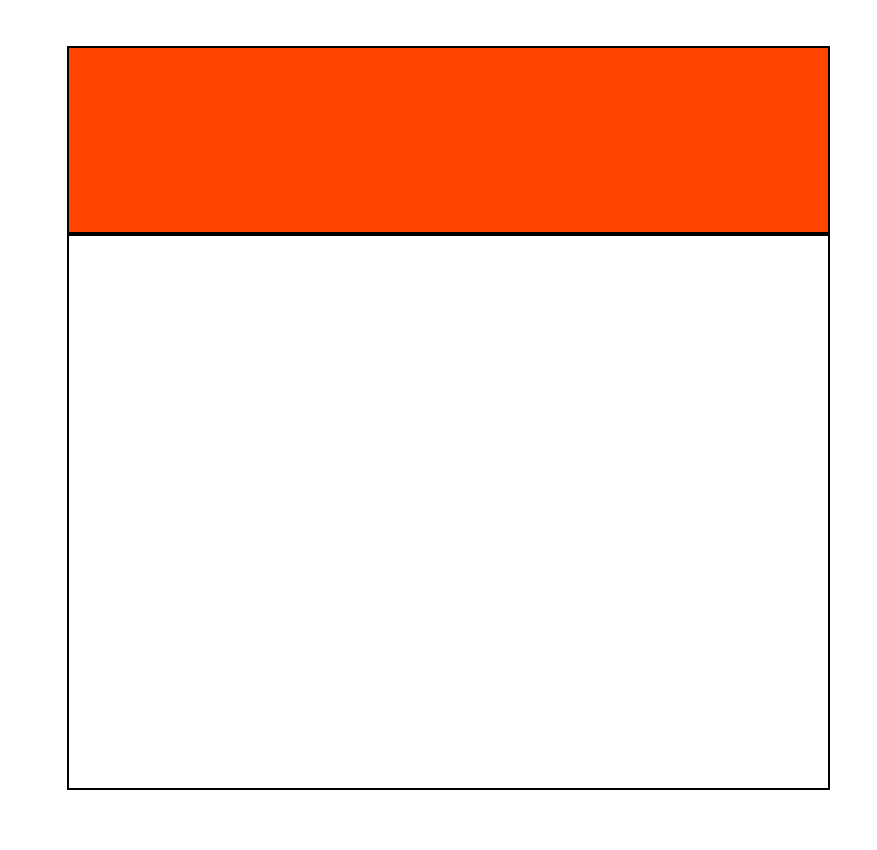

In [96]:
random_mondrians(box, 1, rows=1, columns=1, color='true_mondrian')

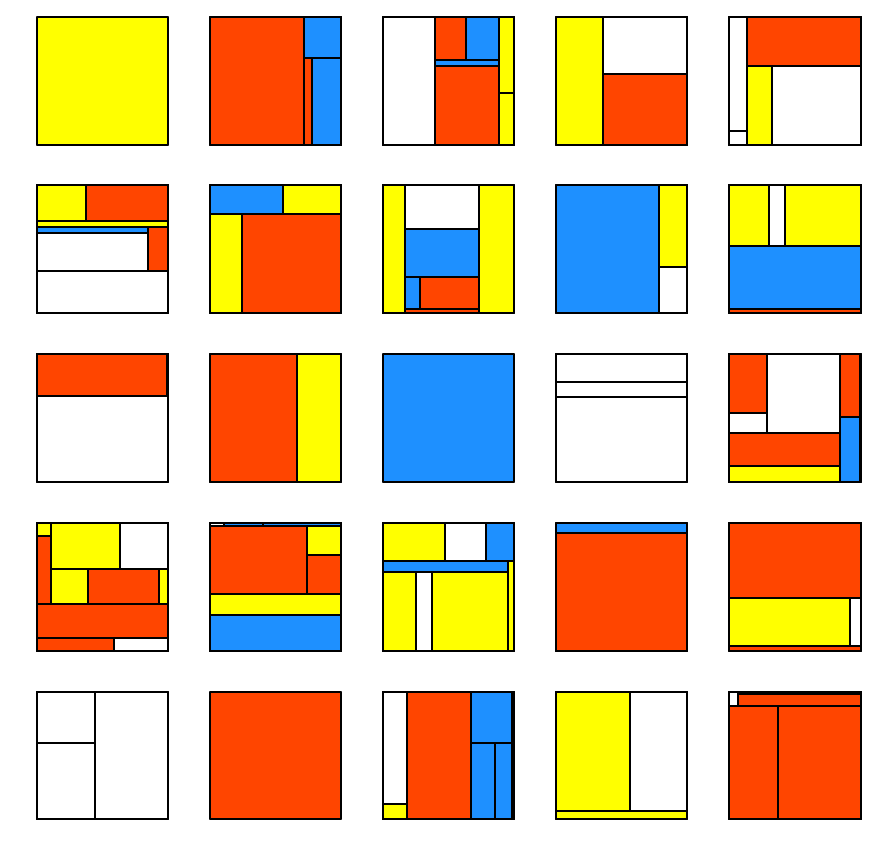

In [97]:
random_mondrians(box, 1, rows=5, columns=5, color='true_mondrian')

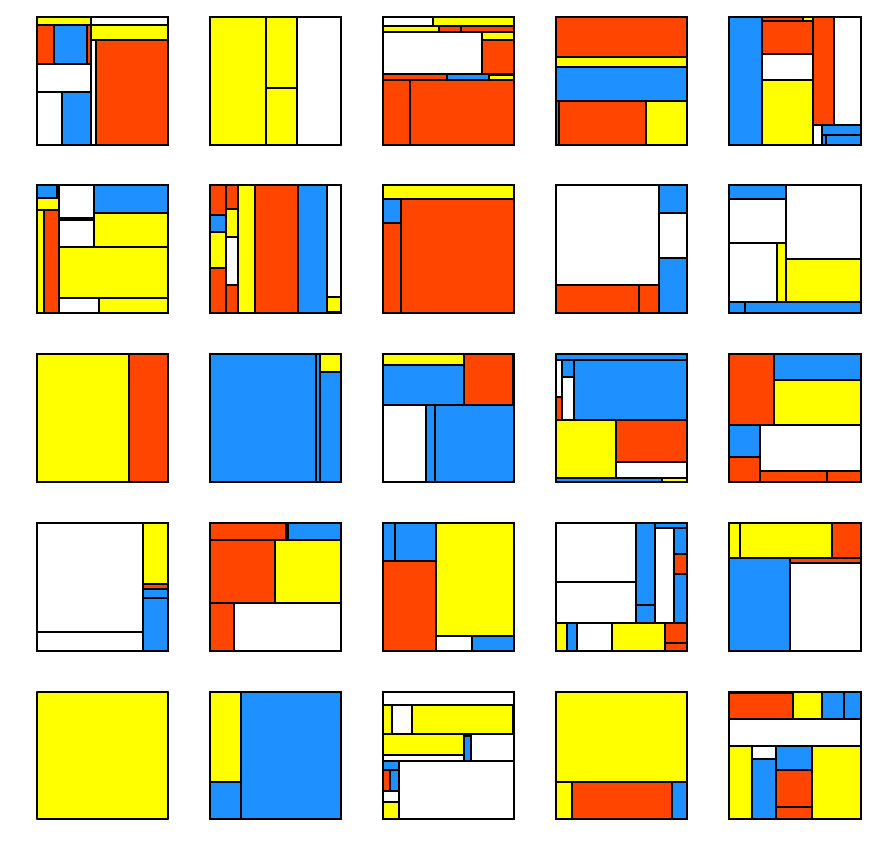

In [98]:
random_mondrians(box, 2, rows=5, columns=5, color='true_mondrian')

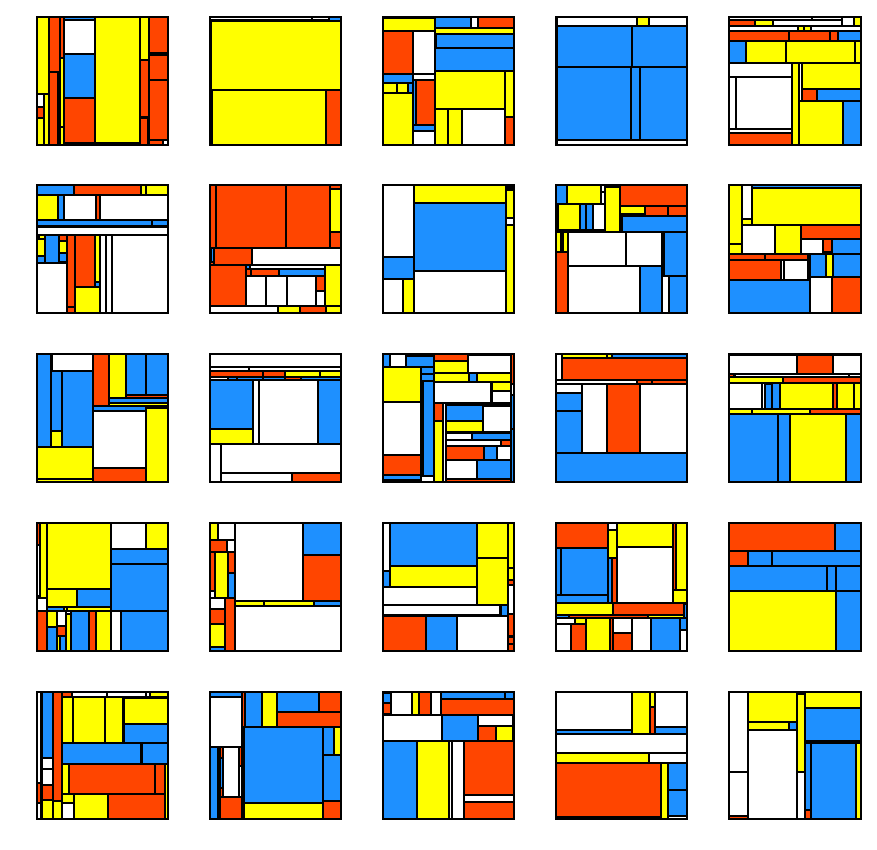

In [99]:
random_mondrians(box, 4, rows=5, columns=5, color='true_mondrian')

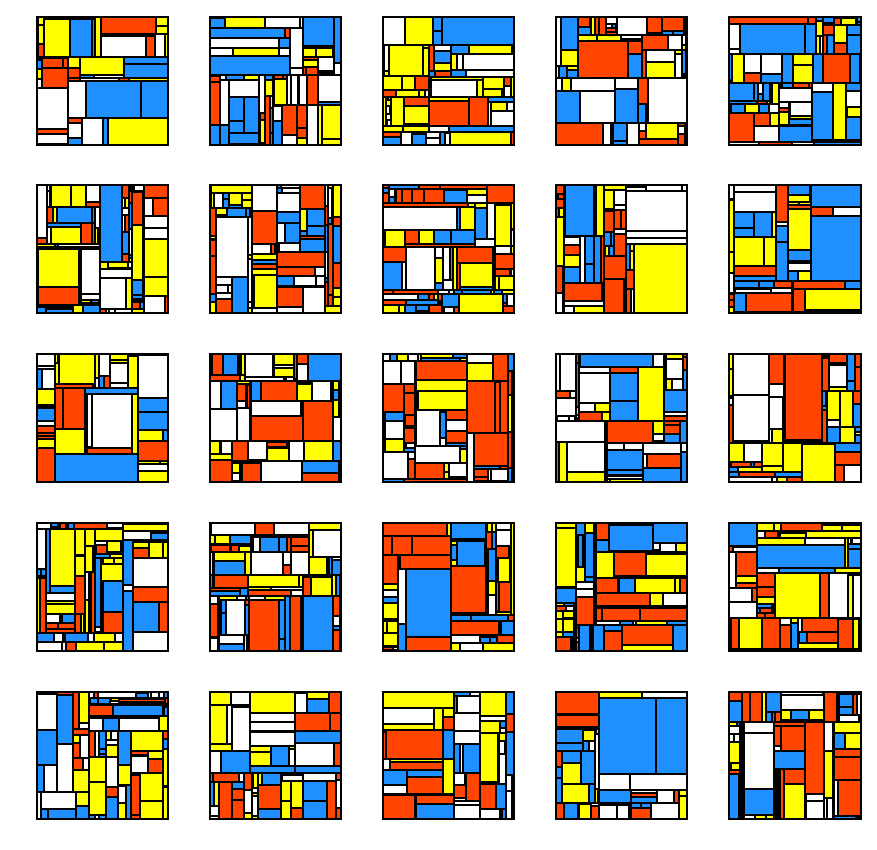

In [100]:
random_mondrians(box, 8, rows=5, columns=5, color='true_mondrian')

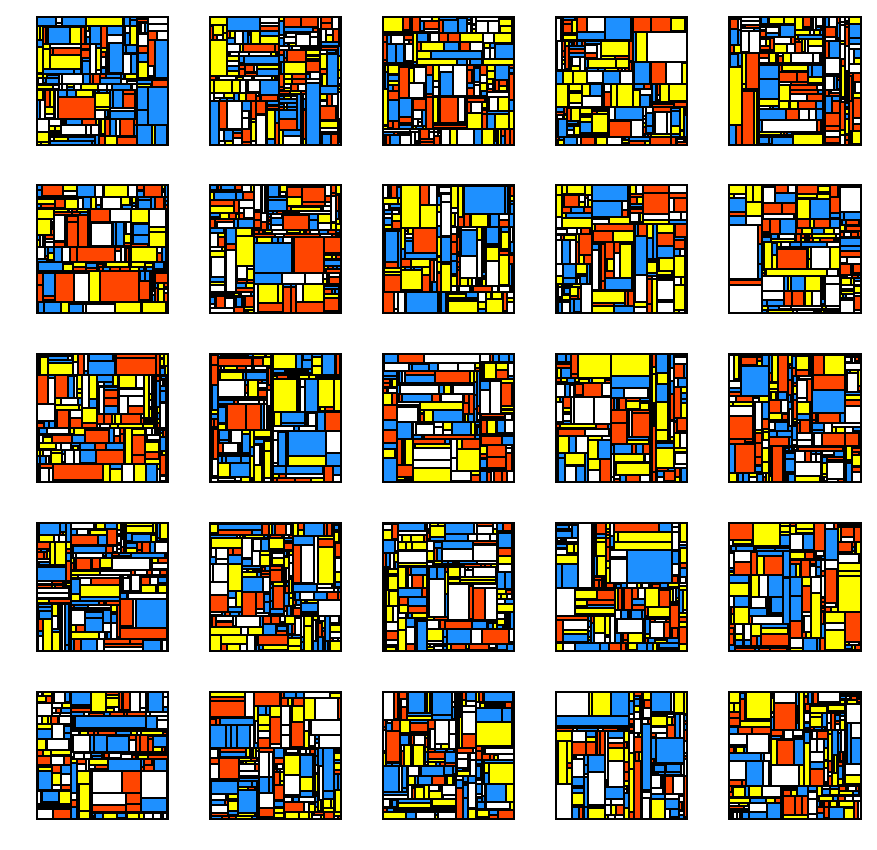

In [101]:
random_mondrians(box, 16, rows=5, columns=5, color='true_mondrian')

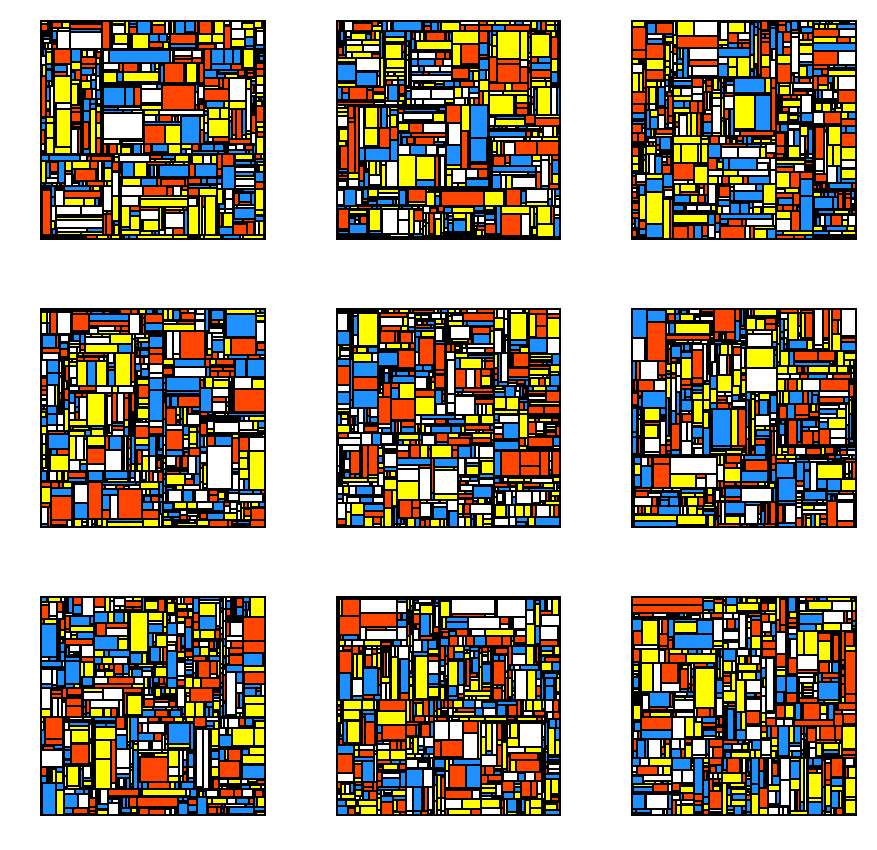

In [102]:
random_mondrians(box, 32, rows=3, columns=3, color='true_mondrian')

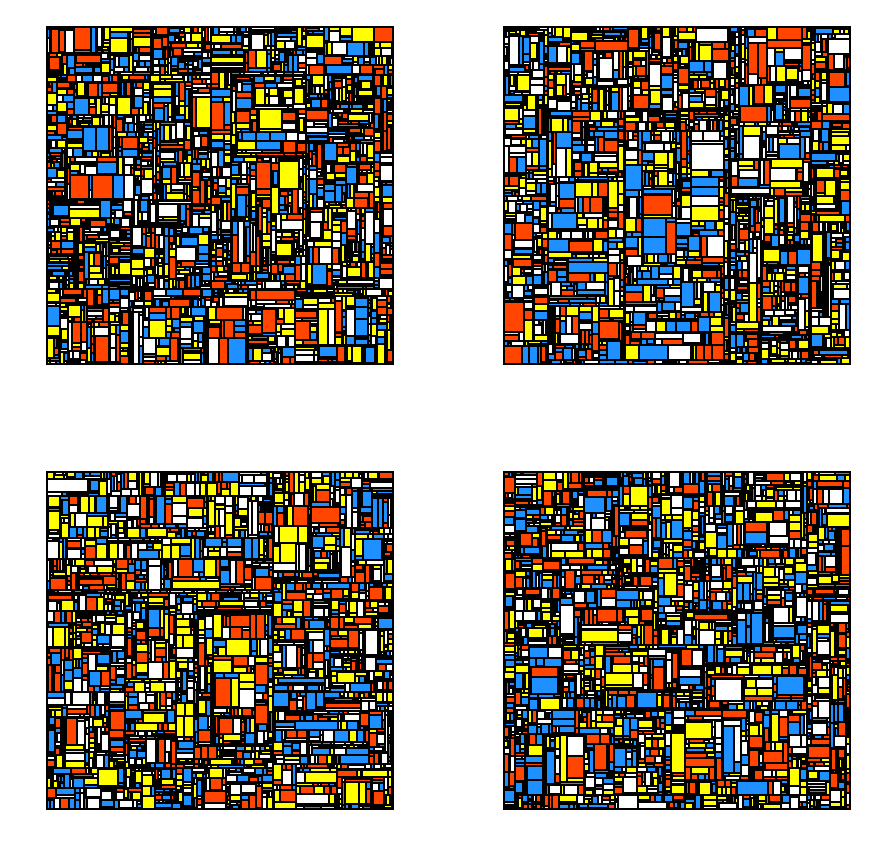

In [103]:
random_mondrians(box, 64, rows=2, columns=2, color='true_mondrian')

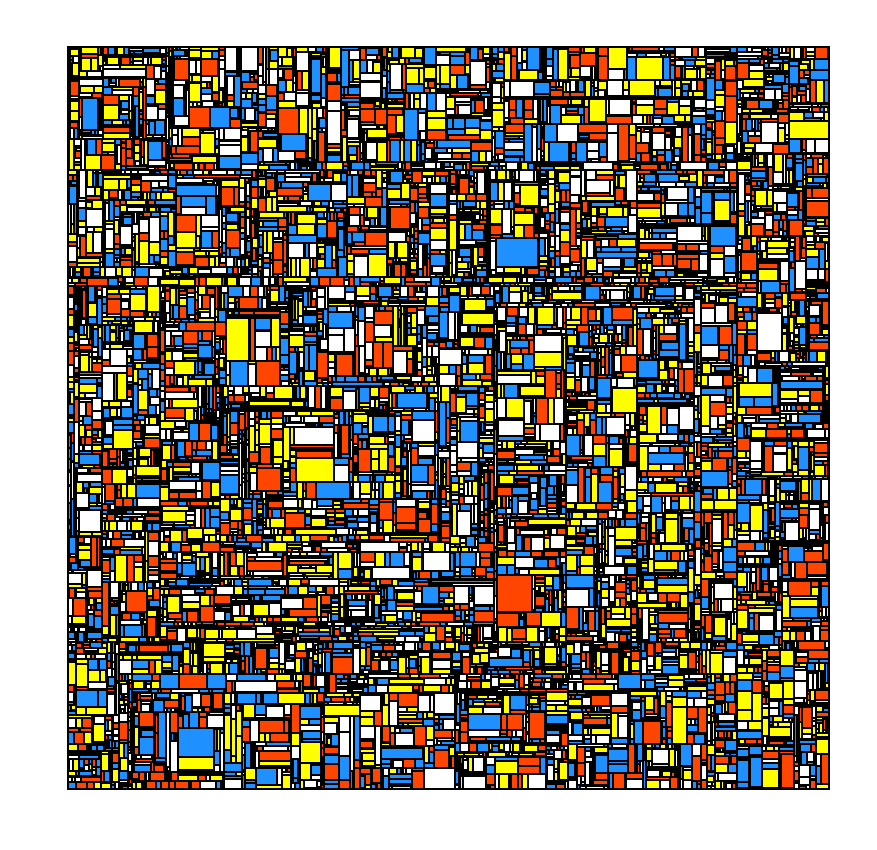

In [52]:
random_mondrians(box, 128, rows=1, columns=1, color='true_mondrian')

And now Mondrians go elliptical: 

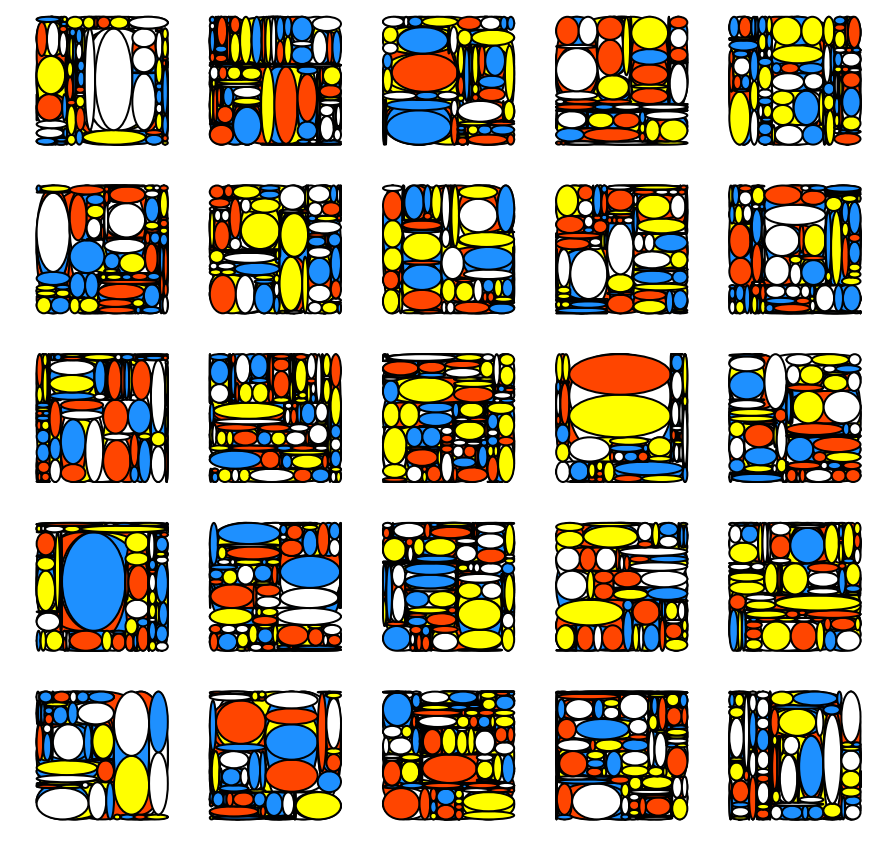

In [104]:
random_mondrians(box, 8, rows=5, columns=5, color='true_mondrian', ellipse=True)

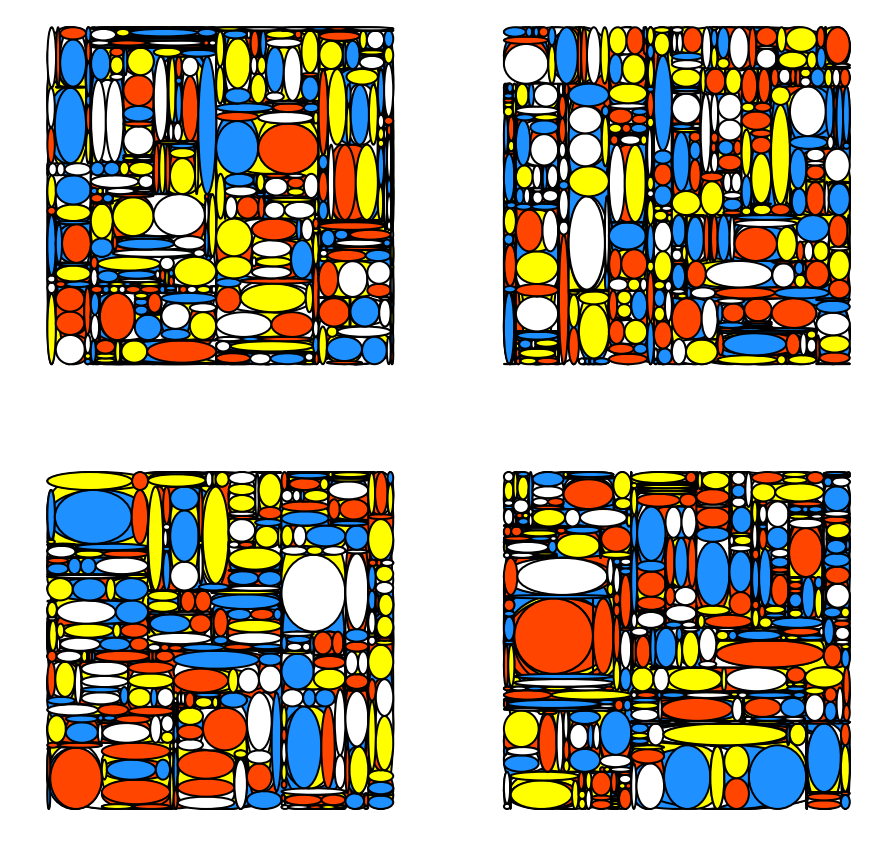

In [105]:
random_mondrians(box, 20, rows=2, columns=2, color='true_mondrian', ellipse=True)

## Conditional Mondrians

Now, just to see how conditional sampling goes, I first sample a Mondrian on a half-by-half square (the top-left) and after a bunch of Mondrians on a 1-by-1 square with the same budget. In these I shade the area corresponding to the smaller Mondrian, so that it is easier to see what is happening. 

/home/javier/VirtualEnvs/v/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


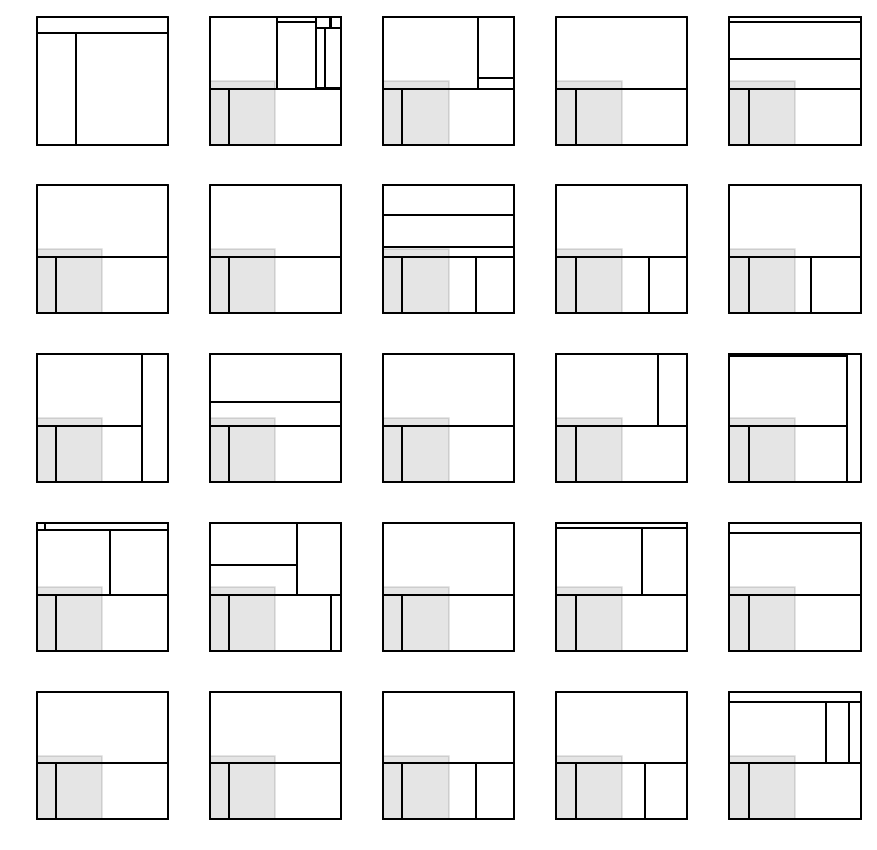

In [58]:
budget = 1
given_mondrian = grow_mondrian(np.array([[0.0, 0.5], [0.0, 0.5]]), budget, Mondrian(None, 1))
box = np.array([[0.0, 1.0], [0.0, 1.0]])
random_mondrians(box, budget, given_mondrian=given_mondrian, rows=5, columns=5)

/home/javier/VirtualEnvs/v/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


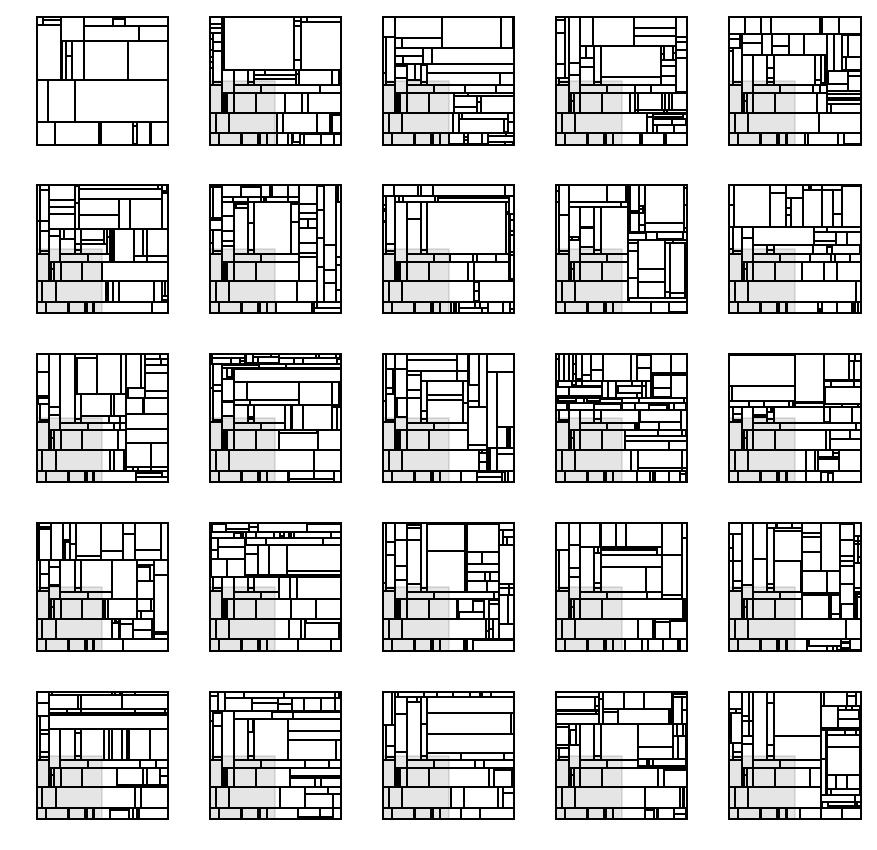

In [59]:
budget = 8
given_mondrian = grow_mondrian(np.array([[0.0, 0.5], [0.0, 0.5]]), budget, Mondrian(None, 1))
box = np.array([[0.0, 1.0], [0.0, 1.0]])
random_mondrians(box, budget, given_mondrian=given_mondrian, rows=5, columns=5)

/home/javier/VirtualEnvs/v/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


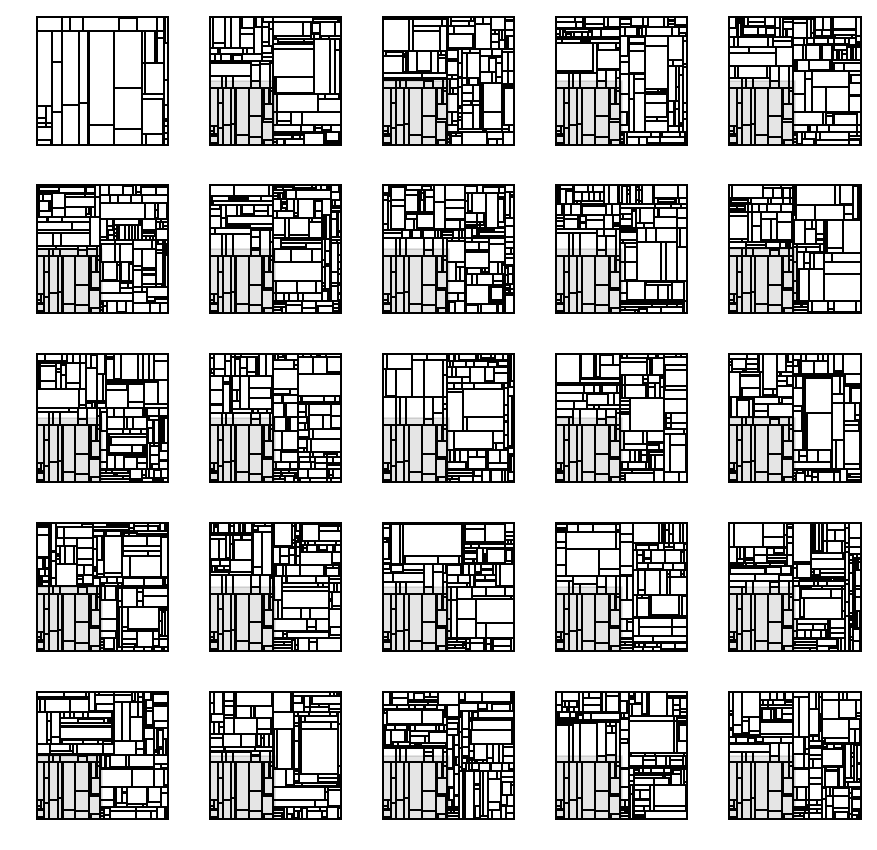

In [60]:
budget = 16
given_mondrian = grow_mondrian(np.array([[0.0, 0.5], [0.0, 0.5]]), budget, Mondrian(None, 1))
box = np.array([[0.0, 1.0], [0.0, 1.0]])
random_mondrians(box, budget, given_mondrian=given_mondrian, rows=5, columns=5)

/home/javier/VirtualEnvs/v/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


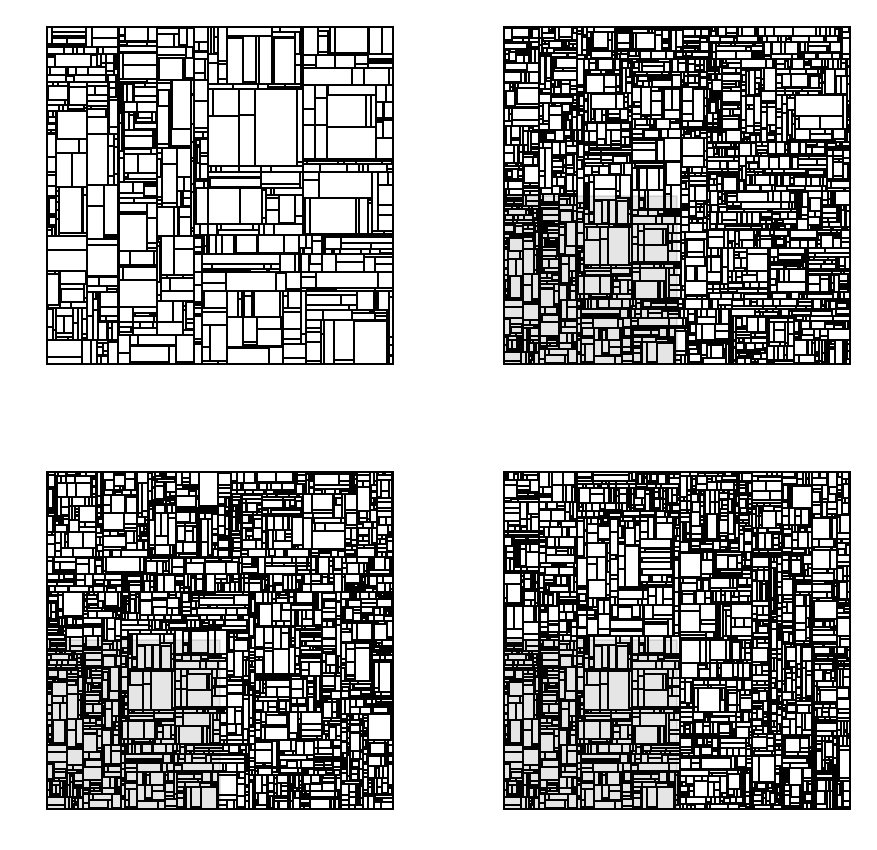

In [61]:
budget = 64
given_mondrian = grow_mondrian(np.array([[0.0, 0.5], [0.0, 0.5]]), budget, Mondrian(None, 1))
box = np.array([[0.0, 1.0], [0.0, 1.0]])
random_mondrians(box, budget, given_mondrian=given_mondrian, rows=2, columns=2)

## Expanding Mondrians

Finally, let us recurrently sample Mondrians conditioned on previous Mondrians starting with a Mondrian on the 1-by-1 square. Each larger domain is four times the size of the previous one.


/home/javier/VirtualEnvs/v/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


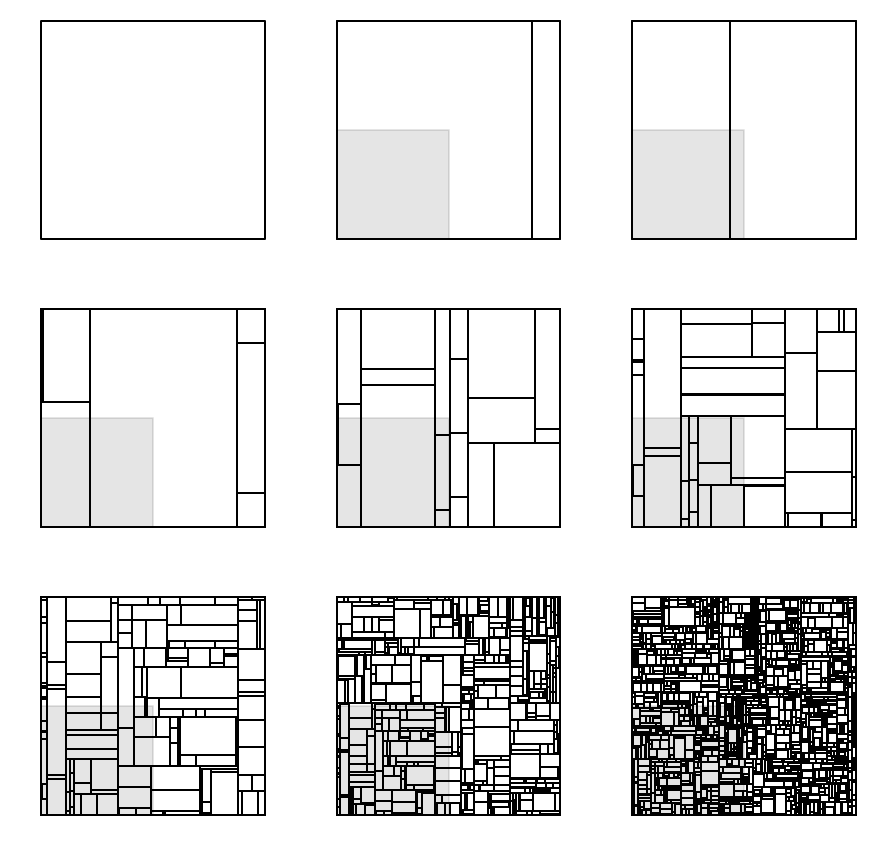

In [77]:
growing_mondrians(box, 0.2, rows=3, columns=3, figsize=(15, 15))